In [1]:
import pandas as pd
import numpy as np
import os 

In [2]:
from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)

In [3]:
#import package
from package.preprocessing import IO

In [4]:
os.listdir("./input/")

['BRCA_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt',
 'CCRCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Normal.txt',
 'CCRCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt',
 'COAD_proteomics_gene_abundance_log2_reference_intensity_normalized_Normal.txt',
 'COAD_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt',
 'GBM_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt',
 'HNSCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Normal.txt',
 'HNSCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt',
 'LSCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Normal.txt',
 'LSCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt',
 'LUAD_proteomics_gene_abundance_log2_reference_intensity_normalized_Normal.txt',
 'LUAD_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt',
 'OV_proteomics_gene

# IO

In [5]:
input_path = "./input/"
export_title = "UCEC "

In [6]:
Normal = IO.read_file(input_path+ "UCEC_proteomics_gene_abundance_log2_reference_intensity_normalized_Normal.txt").set_index("idx").T
Tumour = IO.read_file(input_path+ "UCEC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt").set_index("idx").T

In [7]:
x = pd.concat([Normal, Tumour], axis = 0).reset_index(drop = True)
y = pd.Series(np.concatenate([np.zeros_like(Normal.index), np.ones_like(Tumour.index)], axis = 0)) == 1

In [8]:
x.head(5)

idx,ENSG00000000003.15,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,ENSG00000001461.17,...,ENSG00000256100.1,ENSG00000260007.3,ENSG00000263639.7,ENSG00000266714.9,ENSG00000268533.1,ENSG00000273820.2,ENSG00000277893.2,ENSG00000278857.1,ENSG00000283154.2,ENSG00000283599.2
0,25.056031,25.574974,23.067145,15.675844,20.470261,28.094431,24.810851,26.870303,23.155502,18.319365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24.260521,25.489734,22.825778,15.042369,21.883914,27.829460,24.570651,25.625965,22.869404,18.472483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24.303117,25.715940,22.381371,NaN,20.294663,28.109559,24.701533,26.335878,23.396554,17.857275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24.785347,25.642173,22.602709,NaN,20.617781,28.230619,24.982953,26.635210,23.277744,18.167248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24.917806,25.680536,22.476198,14.918475,20.887053,27.698932,25.422497,25.740944,22.574723,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
x.columns = [col.split(".")[0] for col in x.columns]
gene_name = gp.convert(query = x.columns.to_list())["name"]
matched = gene_name == "None"
x.columns = x.columns.where(matched, gene_name) 

In [10]:
x.head(5)

,TSPAN6,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,NIPAL3,...,ENSG00000256100,ENSG00000260007,MSMB,MYO15B,ENSG00000268533,USP27X,SRD5A2,IGKV1D-12,IQCJ-SCHIP1,ENSG00000283599
0,25.056031,25.574974,23.067145,15.675844,20.470261,28.094431,24.810851,26.870303,23.155502,18.319365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24.260521,25.489734,22.825778,15.042369,21.883914,27.829460,24.570651,25.625965,22.869404,18.472483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24.303117,25.715940,22.381371,NaN,20.294663,28.109559,24.701533,26.335878,23.396554,17.857275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24.785347,25.642173,22.602709,NaN,20.617781,28.230619,24.982953,26.635210,23.277744,18.167248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24.917806,25.680536,22.476198,14.918475,20.887053,27.698932,25.422497,25.740944,22.574723,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
y.head(5)

0    False
1    False
2    False
3    False
4    False
dtype: bool

# Preprocessing

### power transform

In [12]:
x = np.power(2, x)

### Impute

In [13]:
from package.preprocessing import impute, bagging

In [14]:
simple = impute.simple_imputer(threshold = 0.5, strategy = "constant")
x, y = simple.fit_transform(x, y)

In [15]:
x.head(5)

,TSPAN6,DPM1,SCYL3,FGR,CFH,FUCA2,GCLC,NFYA,LAS1L,ENPP4,...,EXOC3L2,SCO2,ENSG00000284691,CCDC39,MIURF,ENSG00000285723,ASDURF,DERPC,BRF2,CCDC18
0,3.488325e+07,4.998437e+07,8.788252e+06,1.452656e+06,2.865936e+08,2.943136e+07,1.226782e+08,9.343305e+06,2.578589e+07,1.205561e+07,...,4.732425e+06,1.608441e+07,1.070022e+06,3.977090e+05,3.950468e+06,3.334000e+06,1.931706e+06,1.107239e+07,985764.252713,737449.496651
1,2.009761e+07,4.711666e+07,7.434367e+06,3.870032e+06,2.385076e+08,2.491741e+07,5.178262e+07,7.662606e+06,2.752292e+07,1.464957e+07,...,6.271575e+06,1.608931e+07,1.173033e+06,6.182474e+05,3.726100e+06,2.883680e+06,1.430176e+06,9.629730e+06,985764.252713,737449.496651
2,2.069984e+07,5.511492e+07,5.463411e+06,1.286182e+06,2.896146e+08,2.728364e+07,8.470114e+07,1.104243e+07,2.681291e+07,1.197475e+07,...,4.898554e+06,1.314227e+07,2.102021e+06,1.504994e+06,4.119604e+06,4.113641e+06,1.951747e+06,1.026969e+07,985764.252713,737449.496651
3,2.891564e+07,5.236766e+07,6.369323e+06,1.609053e+06,3.149656e+08,3.316028e+07,1.042311e+08,1.016949e+07,2.801138e+07,1.305568e+07,...,6.093974e+06,1.600178e+07,1.583514e+06,1.504994e+06,4.017998e+06,4.326970e+06,1.409946e+06,9.443555e+06,985764.252713,737449.496651
4,3.169618e+07,5.377887e+07,5.834582e+06,1.939231e+06,2.178760e+08,4.497117e+07,5.607849e+07,6.246959e+06,3.038504e+07,1.465062e+07,...,5.735335e+06,1.676157e+07,1.146028e+06,4.487344e+05,4.514072e+06,4.038558e+06,1.541346e+06,9.352281e+06,985764.252713,737449.496651


### Bagging

bagger = bagging.bagger()
x, y = bagger.fit_transform(x, y)

print(bagger.see("AAMP")) # AAMP is a feature
print(bagger.see("AA"))   # no AA but some other feature start with AA
print(bagger.see("AA*"))  # * can list all features start with ZN
try:
    print(bagger.see("ERROR"))
except:
    print("ERROR is not a feature in x, it will raise an error")

# Feature selection

In [16]:
from package.selection.ensemble import selector
from package.selection.Volcano import Volcano_selection

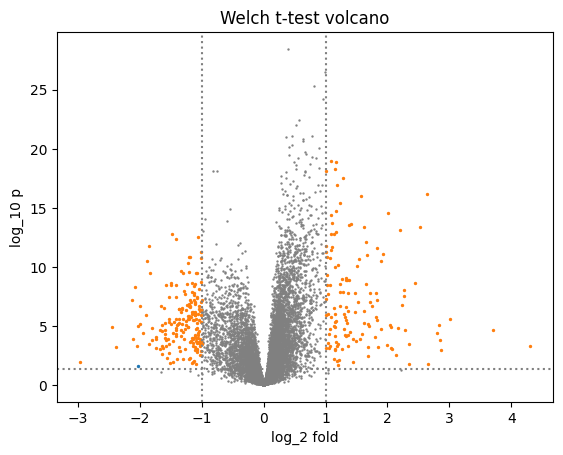

In [17]:
vol = Volcano_selection(strategy = "p", log_domain=False, absolute= False)
vol_importance = vol.select(x, y, -1)
vol.plotting()

In [18]:
ensemble_selector = selector()
important_feature, importance = ensemble_selector.select(x, y, 100)

Using  c45  to select.


100%|██████████| 9819/9819 [00:23<00:00, 421.07it/s]


c45  is done.

Using  RF_gini  to select.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

RF_gini  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running
AdaBoost  is done.

Using  Lasso  to select.


  6%|▌         | 60/999 [00:06<01:42,  9.13it/s]


all coefficient are dead, terminated.
Lasso  is done.

Using  multi_Lasso  to select.


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e-02, tolerance: 2.825e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-02, tolerance: 2.825e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pac

multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  XGboost  to select.


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(

XGboost  is done.

Using  Lightgbm  to select.
[LightGBM] [Info] Number of positive: 95, number of negative: 18
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368853
[LightGBM] [Info] Number of data points in the train set: 113, number of used features: 9819
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [19]:
important_feature

,DT_score_c45,RandomForest_gini,AdaBoost64,LassoLinear,multi_Lasso,SVM,XGboost,Lightgbm
0,PDGFRA,PLPP1,PDGFRA,COX7A1,COX7A1,GUSB,PDGFRA,PDGFRA
1,S100A2,MXRA7,NaN,GUSB,ALDH1A2,FTH1,NaN,TSPAN6
2,KRT13,PDGFRA,NaN,CDH11,GUSB,HRC,NaN,CFH
3,SSPN,PALM,NaN,PDGFRB,TSHZ3,DDB2,NaN,ENPP4
4,DKK4,RFTN1,NaN,PDGFRA,PALM,COX7A1,NaN,SCYL3
...,...,...,...,...,...,...,...,...
95,PITRM1,A1BG,NaN,NaN,WNT2,ATP6V0C,NaN,NaN
96,ACBD7,GNA11,NaN,NaN,CD248,PCBP3,NaN,NaN
97,LAMC2,S100A9,NaN,NaN,HAND2,GUCY1B1,NaN,NaN
98,VSNL1,NDN,NaN,NaN,ECM1,GZMB,NaN,NaN


In [20]:
importance

,DT_score_c45,RandomForest_gini,AdaBoost64,LassoLinear,multi_Lasso,SVM,XGboost,Lightgbm
PDGFRA,0.845984,0.009487,1.0,0.22,0.022537,0.000588,1.0,100.0
S100A2,0.840817,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KRT13,0.840798,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SSPN,0.840524,NaN,NaN,NaN,NaN,0.000441,NaN,NaN
DKK4,0.840077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
CD99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
DPM1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
ITGA2B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
FGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


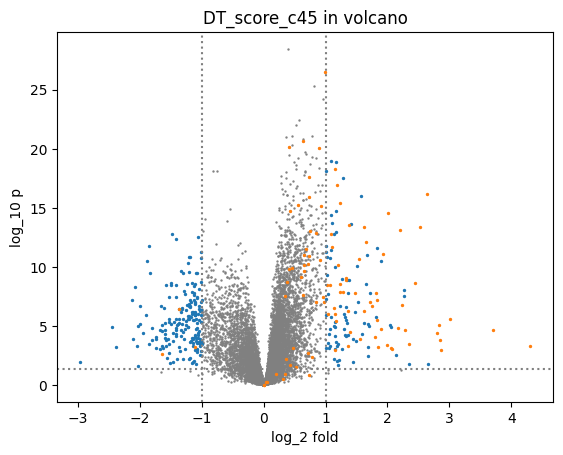

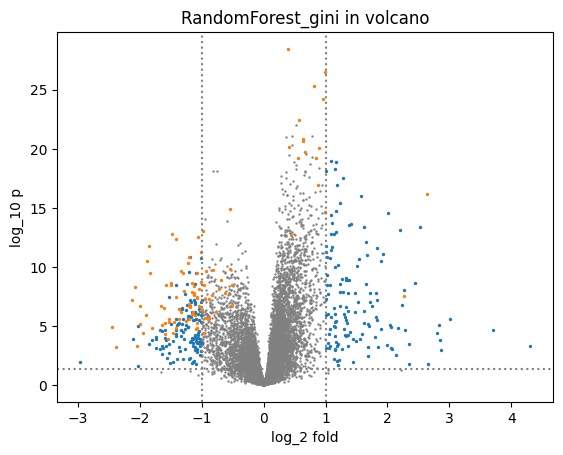

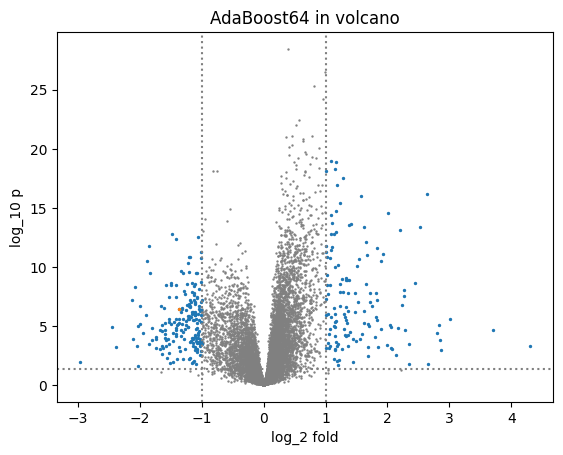

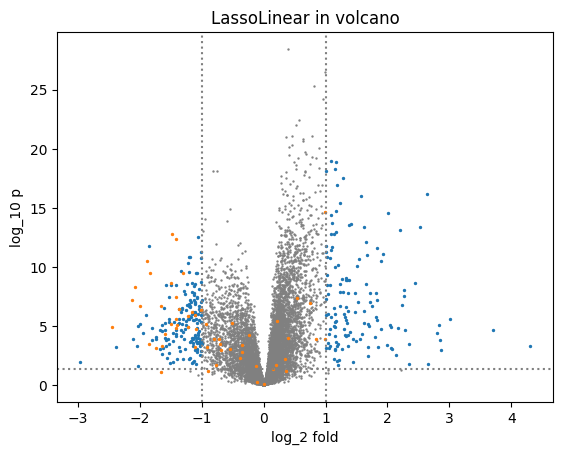

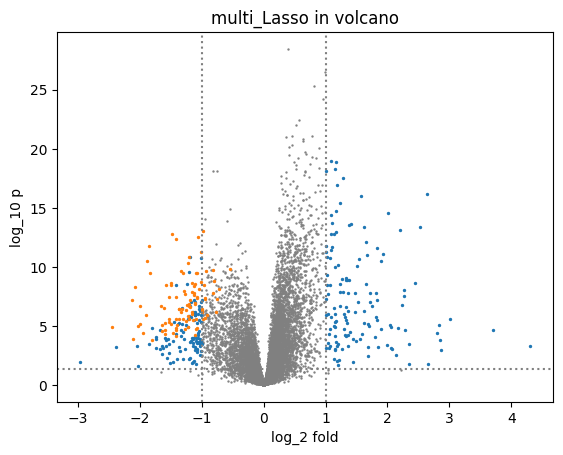

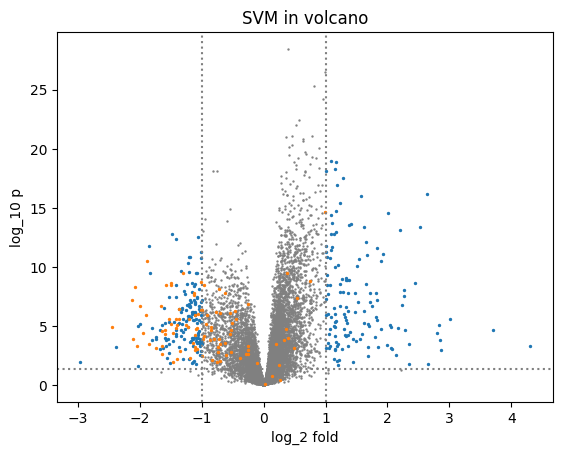

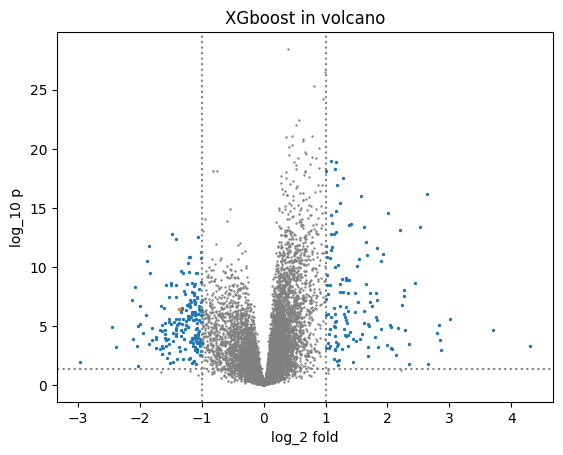

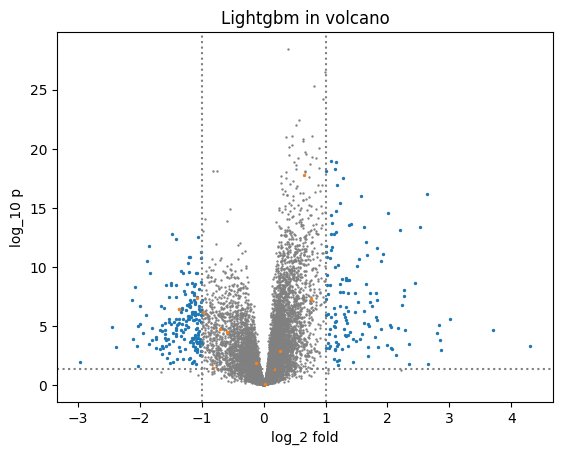

In [21]:
for method in importance:
    vol.plotting(
        external=True,
        external_score=importance[method].dropna(), 
        title = method+" in volcano",
        show = False, 
        saving = True, 
        save_path = "./output/images/"+ export_title)

### Modeling

In [22]:
from sklearn.svm import SVC
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [23]:
x = (x-x.mean())/x.std()

In [24]:
class SVC_tuner():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __call__(self, trial):
        svc_c = trial.suggest_float("svc_c", 1e-5, 1e3, log=True)
        classifier_obj = SVC(C = svc_c, cache_size = 1e+3, class_weight = "balanced", gamma="auto", probability=True)
        
        score = cross_val_score(classifier_obj, self.x, self.y, n_jobs=-1, cv=5, scoring = "neg_log_loss")#
        accuracy = score.mean()
        return accuracy

In [25]:
svm_performance = []
for k in [5, 10, 20]:
    performance = {}
    for method in important_feature.columns:
        top_k = important_feature.head(k)[method].dropna()
        task = SVC_tuner(x[top_k], y)
        study = optuna.create_study(direction="maximize")
        study.optimize(task, n_trials=200)
        
        best_svc_c = study.best_trial.params["svc_c"]
        
        best_svc = SVC(C = best_svc_c, probability = True, cache_size = 1e+3, class_weight = "balanced", gamma="auto").fit(x[top_k], y)
        prob = best_svc.predict_proba(x[top_k])

        performance[method] = roc_auc_score(y, (prob[:, 1] +(1-prob[:, 0]))/2)
    svm_performance.append(pd.Series(performance, name = "top"+ str(k)))
svm_performance


[I 2024-05-26 17:42:14,042] A new study created in memory with name: no-name-ed39174b-fc5f-4687-8932-ae8a19517a3e
[I 2024-05-26 17:42:16,937] Trial 0 finished with value: -0.10953802961475126 and parameters: {'svc_c': 26.394354421202348}. Best is trial 0 with value: -0.10953802961475126.
[I 2024-05-26 17:42:18,035] Trial 1 finished with value: -0.4645166326344671 and parameters: {'svc_c': 0.002687765541917836}. Best is trial 0 with value: -0.10953802961475126.
[I 2024-05-26 17:42:18,078] Trial 2 finished with value: -0.46582821231911664 and parameters: {'svc_c': 0.005477447247144592}. Best is trial 0 with value: -0.10953802961475126.
[I 2024-05-26 17:42:18,112] Trial 3 finished with value: -0.5253132464807279 and parameters: {'svc_c': 1.8653622483381043e-05}. Best is trial 0 with value: -0.10953802961475126.
[I 2024-05-26 17:42:18,142] Trial 4 finished with value: -0.10704044743832206 and parameters: {'svc_c': 0.6146286689500208}. Best is trial 4 with value: -0.10704044743832206.
[I 20

[DT_score_c45         1.0
 RandomForest_gini    1.0
 AdaBoost64           1.0
 LassoLinear          1.0
 multi_Lasso          1.0
 SVM                  1.0
 XGboost              1.0
 Lightgbm             1.0
 Name: top5, dtype: float64,
 DT_score_c45         1.0
 RandomForest_gini    1.0
 AdaBoost64           1.0
 LassoLinear          1.0
 multi_Lasso          1.0
 SVM                  1.0
 XGboost              1.0
 Lightgbm             1.0
 Name: top10, dtype: float64,
 DT_score_c45         1.0
 RandomForest_gini    1.0
 AdaBoost64           1.0
 LassoLinear          1.0
 multi_Lasso          1.0
 SVM                  1.0
 XGboost              1.0
 Lightgbm             1.0
 Name: top20, dtype: float64]

In [26]:
svm_performance = pd.concat(svm_performance, axis = 1)

### unbagging
important_feature = important_feature.map(bagger.unbagging) 

### g:profiler

In [27]:
gp_enrichment_result = []
for method in important_feature.columns:
    gp_result = gp.profile(query = important_feature[method].dropna().to_list()).sort_values("p_value")
    gp_result["method"] = method
    gp_enrichment_result.append(gp_result[["method", "source", "native", "parents", "p_value", "description", "intersection_size"]])
gp_enrichment_result = pd.concat(gp_enrichment_result, axis = 0).reset_index(drop = True)
gp_enrichment_result


,method,source,native,parents,p_value,description,intersection_size
0,DT_score_c45,GO:CC,GO:0005576,[GO:0110165],2.236397e-11,"""The space external to the outermost structure...",50
1,DT_score_c45,GO:CC,GO:0005615,"[GO:0005576, GO:0110165]",1.903943e-10,"""That part of a multicellular organism outside...",43
2,DT_score_c45,GO:CC,GO:0070062,"[GO:0005615, GO:1903561]",1.446527e-06,"""A vesicle that is released into the extracell...",29
3,DT_score_c45,GO:CC,GO:1903561,"[GO:0031982, GO:0065010]",1.870172e-06,"""Any vesicle that is part of the extracellular...",29
4,DT_score_c45,GO:CC,GO:0065010,"[GO:0043227, GO:0043230]",1.890138e-06,"""Organized structure of distinctive morphology...",29
...,...,...,...,...,...,...,...
478,Lightgbm,GO:CC,GO:0070062,"[GO:0005615, GO:1903561]",2.370365e-02,"""A vesicle that is released into the extracell...",6
479,Lightgbm,GO:CC,GO:1903561,"[GO:0031982, GO:0065010]",2.524358e-02,"""Any vesicle that is part of the extracellular...",6
480,Lightgbm,GO:CC,GO:0043230,"[GO:0005576, GO:0043226]",2.530945e-02,"""Organized structure of distinctive morphology...",6
481,Lightgbm,GO:CC,GO:0065010,"[GO:0043227, GO:0043230]",2.530945e-02,"""Organized structure of distinctive morphology...",6


# Output

In [28]:
important_feature.to_csv("./output/"+export_title+ " important feature.csv")
importance.to_csv("./output/"+export_title+ " importance.csv")
gp_enrichment_result.to_csv("./output/"+export_title+ " g_prophiler.csv")
svm_performance.to_csv("./output/"+export_title+ " rbfSVM_performance.csv")
vol_importance.to_csv("./output/"+export_title+ " volcano_foldchange.csv")